With inspiration from : https://towardsdatascience.com/my-deep-learning-model-says-sorry-i-dont-know-the-answer-that-s-absolutely-ok-50ffa562cb0b

In [2]:
import sys
import os
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('..'))

sys.path.insert(1, module_path + '/src')
import audio_time_series_classification as preproject
import utility

sys.path.insert(1, module_path + '/src/models/')
import helper

from sklearn.decomposition import PCA
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.feature_selection import SelectKBest, chi2
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

figure_path = module_path + '/figures/'

In [3]:
ts_path = module_path + '/data/ts_files/crackleNoCrackle_FULL.ts'
#NB ! This file has already been downsampled and denoised before saving
kwargs_ls = {
    'ts_file_path': ts_path,
    'sr' : 8000,
    'UCR_file': False,
    'n_mfcc' : 30,
    'denoise' : False,
    'downsample' : False,
    'downsample_new_sr' : 8000,
    'update' : False,
    'name' : 'lungsound',
    'module_path' : module_path
}

ls = preproject.overproduced_audio_time_series_features(**kwargs_ls)

X_train, X_test, y_train, y_test = ls.get_X_y_transformed(train_test_split = True)

In [4]:
y_train.value_counts()

0    3589
1    1929
Name: 0, dtype: int64

In [6]:
import random
from sklearn import metrics

from fylearn.nfpc import FuzzyPatternClassifier
from fylearn.fpt import FuzzyPatternTreeTopDownClassifier

random.seed(0)

clf = FuzzyPatternTreeTopDownClassifier()

auc = []
ignorance = []
conflict = []

indices_0 = np.where(y_train.astype(int) == 0)[0]
indices_1 = np.where(y_train.astype(int) == 1)[0]
indices = np.concatenate((indices_0[0:1929], indices_1))


for i in range(100, len(indices), 100):

    p = indices.copy()
    random.shuffle(p)
    indices_2 = p[0:i]
    

    clf.fit(X_train.iloc[indices_2], y_train.iloc[indices_2])

    pred, t = clf.predict(X_test)
    
    auc_score = metrics.roc_auc_score(y_test, pred)
    
    ig = np.where((((t< 0.45)[: , 0]) & ((t< 0.45)[: , 1])) == True)[0]
    ignorant_indices = len(ig)
    print(ig)

    conf = np.where((((t> 0.55)[: , 0]) & ((t> 0.55)[: , 1])) == True)[0]
    conflict_indices = len(conf)
    print(conflict_indices)
    
    conflict.append(conflict_indices)
    ignorance.append(ignorant_indices)
    auc.append(auc_score)
    #break


[   5   19   30   65   90   93  113  165  169  183  192  196  221  261
  281  296  310  317  386  396  398  412  427  429  438  453  494  508
  565  586  609  628  653  660  670  676  703  708  712  724  735  765
  778  816  819  831  849  857  867  905  926  942  943  975  977  979
  992  997 1030 1032 1041 1047 1056 1082 1096 1111 1117 1155 1167 1178
 1180 1214 1215 1231 1239 1253 1263 1271 1301 1303 1338 1341 1348]
99
[   8   12   32   36   41   42   50   53   60   75   90  108  122  123
  140  161  167  177  179  192  195  227  237  242  265  270  281  294
  303  305  312  315  330  332  336  343  344  356  361  372  376  377
  393  409  413  414  421  423  445  456  462  463  480  481  485  498
  503  508  528  530  532  533  554  562  568  580  615  621  652  663
  672  675  686  690  695  703  712  714  724  728  739  740  793  804
  805  813  819  831  845  847  868  884  890  899  901  921  943  944
  965  970  978  982  986  992  993  995 1000 1007 1009 1021 1029 1034
 1038 1

In [4]:


clf = FuzzyPatternTreeTopDownClassifier()

clf.fit(X_train.iloc[indices], y_train.iloc[indices])

pred, t = clf.predict(X_test)

In [14]:
clf.get_params()

{'similarity_measure': <function fylearn.fpt.default_rmse(a, b)>,
 'relative_improvement': 0.01,
 'num_candidates': 5,
 'fuzzifier': <function fylearn.fpt.default_fuzzifier(idx, F)>}

Example bounderies 

* Episentric uncertainty degree = min(u1, u2)
* Aleatoric uncertainty degree = 1 - max(u1,u2)

Test: 
*  > 0.6 and < 0.4 --> Certain
*  > 0.6 and > 0.6 --> Conflict
*  < 0.4 and < 0.4 --> Ignorant 

In [43]:
ignorant_indices = np.where((((t< 0.45)[: , 0]) & ((t< 0.45)[: , 1])) == True)

conflict_indices = np.where((((t> 0.55)[: , 0]) & ((t> 0.55)[: , 1])) == True)

In [22]:
np.where(((t < 0.5) == [True, True]))

(array([   0,    1,    2, ..., 1377, 1378, 1379]),
 array([0, 0, 0, ..., 1, 1, 1]))

In [46]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train, y_train)
f, ax = helper.scatterplot_with_colors(p2[0], y_train.values.astype(int),
                                       module_path, new_legends = ['no crackle', 'crackle'],
                                       x_y_labels = ['PLSR1', 'PLSR2'])

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/andrine/Desktop/src/visualization/CharterRegular.ttf'

<Figure size 288x288 with 1 Axes>

In [ ]:
np.where((t[:, 1] < 0.3) == True)

In [12]:
np.where((t[:, 1] < 0.3) == True)

(array([   5,    6,   33,   36,   48,   60,   90,   91,  108,  117,  121,
         168,  174,  189,  206,  250,  261,  268,  275,  277,  281,  326,
         336,  356,  373,  377,  393,  412,  453,  474,  477,  478,  498,
         503,  505,  508,  597,  608,  610,  622,  637,  653,  671,  701,
         778,  783,  799,  831,  836,  852,  902,  906,  953,  992,  993,
        1008, 1011, 1047, 1049, 1082, 1098, 1099, 1114, 1123, 1156, 1161,
        1171, 1174, 1214, 1231, 1232, 1239, 1240, 1243, 1245, 1255, 1265,
        1276, 1297, 1351]),)

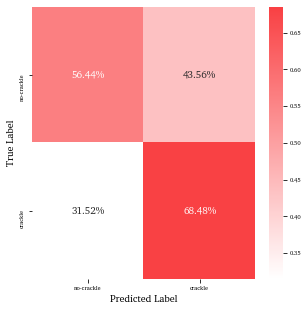

In [13]:
f, ax = utility.plot_cm(y_test.to_numpy().astype(int), pred.astype(int), module_path = module_path)

In [16]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2

# function for creating a fully connected neural network of any architecture
# the number of neurons in each layer is defined by layers_shape
# the droupout_proba indicates if dropout layers should be added
def architecture(layers_shape, input_dim, output_dim, dropout_proba, reg, act='relu', verbose=False):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act,
                   kernel_regularizer=l2(reg))(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
            hidden = Dropout(dropout_proba)(hidden, training=True)
        hidden = Dense(layers_shape[i+1], activation=act, kernel_regularizer=l2(reg))(hidden)
    if dropout_proba > 0:
        hidden = Dropout(dropout_proba)(hidden, training=True)
    outputs = Dense(output_dim, kernel_regularizer=l2(reg))(hidden) 
    model = Model(inputs, outputs)
    if verbose:
        model.summary()
    return model
  
model_without_dropout = architecture(layers_shape=[100, 50, 10], input_dim= 218, output_dim=2, 
                                     dropout_proba=0, reg=0, act='relu', verbose=1)

model_with_dropout = architecture(layers_shape=[100, 50, 10], input_dim= 218, output_dim=2, 
                                  dropout_proba=0.05, reg=0.00475, act='relu', verbose=1)

here
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 218)]             0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               21900     
_________________________________________________________________
dense_33 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_34 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 22        
Total params: 27,482
Trainable params: 27,482
Non-trainable params: 0
_________________________________________________________________
here
Model: "model_7"
_________________________________________________________________
Layer (type)                

In [11]:
X_train.shape

(5518, 218)

In [19]:
model_without_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_without_dropout = model_without_dropout.fit(X_train.iloc[indices], y_train.iloc[indices], batch_size=10, 
                                                    epochs=500, shuffle=True, verbose=0)

# training the network with dropout
model_with_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_with_dropout = model_with_dropout.fit(X_train.iloc[indices], y_train.iloc[indices], batch_size=10, 
                                              epochs=500, shuffle=True, verbose=0)

UnimplementedError:  Cast string to float is not supported
	 [[node mean_squared_error/Cast (defined at <ipython-input-19-1c20a7c287bf>:3) ]] [Op:__inference_train_function_4929]

Function call stack:
train_function


In [ ]:
# training performance
epochs = range(1, len(history_without_dropout.history['loss']) + 1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(epochs, history_without_dropout.history['loss'], 'b')
ax[0].set_title('Training loss without dropout')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].plot(epochs, history_with_dropout.history['loss'], 'r')
ax[1].set_title('Training loss with dropout')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss');

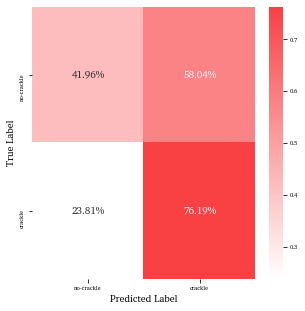

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
clf = GaussianNB()
clf.fit(X_train.iloc[indices], y_train.iloc[indices])
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)

f, ax = utility.plot_cm(y_test.to_numpy().astype(int), pred.astype(int), module_path = module_path)

In [47]:
prob

array([[5.38011686e-13, 1.00000000e+00],
       [9.00721984e-15, 1.00000000e+00],
       [1.07032584e-15, 1.00000000e+00],
       ...,
       [9.99999999e-01, 1.32900359e-09],
       [9.99999707e-01, 2.93181240e-07],
       [9.91322467e-01, 8.67753337e-03]])